In [63]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.image as mpimg

from sklearn.metrics import classification_report

from keras.models import Sequential 
from keras.layers import Dense, Dropout, Activation, Conv1D, Conv2D, Flatten, MaxPool2D, AvgPool2D, BatchNormalization, GlobalAveragePooling2D
from keras import optimizers

np.random.seed(0)

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img

#PW: added warning ignore
import warnings
warnings.filterwarnings('ignore')
import time

In [10]:
# Here we extract the data files (NOTE: please enter data path)
path_train = '../Data/training/training.csv'
path_test = '../Data/test/test.csv' 

df_train = pd.read_csv(path_train)
df_test = pd.read_csv(path_test)

In [11]:
# Processing training data such that each pixel has its own column and is seperated from the labels
kaggle_train = df_train.loc[:,'Image'].T
kaggle_train = kaggle_train.astype(str)
kaggle_train = kaggle_train.str.split(" ", expand = True) 
kaggle_train.head()

,0,1,2,3,4,5,6,7,8,9,...,9206,9207,9208,9209,9210,9211,9212,9213,9214,9215
0,238,236,237,238,240,240,239,241,241,243,...,33,29,30,34,39,49,62,70,75,90
1,219,215,204,196,204,211,212,200,180,168,...,1,1,1,1,1,1,1,1,1,1
2,144,142,159,180,188,188,184,180,167,132,...,64,60,56,61,70,69,71,78,78,77
3,193,192,193,194,194,194,193,192,168,111,...,1,1,1,1,1,1,1,1,1,1
4,147,148,160,196,215,214,216,217,219,220,...,33,34,37,37,43,46,83,140,170,176


In [12]:
# Creates labels for facial feature position
labels = df_train.iloc[:, 0:30] 
labels.columns

Index(['left_eye_center_x', 'left_eye_center_y', 'right_eye_center_x',
       'right_eye_center_y', 'left_eye_inner_corner_x',
       'left_eye_inner_corner_y', 'left_eye_outer_corner_x',
       'left_eye_outer_corner_y', 'right_eye_inner_corner_x',
       'right_eye_inner_corner_y', 'right_eye_outer_corner_x',
       'right_eye_outer_corner_y', 'left_eyebrow_inner_end_x',
       'left_eyebrow_inner_end_y', 'left_eyebrow_outer_end_x',
       'left_eyebrow_outer_end_y', 'right_eyebrow_inner_end_x',
       'right_eyebrow_inner_end_y', 'right_eyebrow_outer_end_x',
       'right_eyebrow_outer_end_y', 'nose_tip_x', 'nose_tip_y',
       'mouth_left_corner_x', 'mouth_left_corner_y', 'mouth_right_corner_x',
       'mouth_right_corner_y', 'mouth_center_top_lip_x',
       'mouth_center_top_lip_y', 'mouth_center_bottom_lip_x',
       'mouth_center_bottom_lip_y'],
      dtype='object')

In [13]:
norm_X_train = kaggle_train.astype(int) / 255. # normalize image pixel to be between 0 and 1

In [14]:
index_none_missing = np.sum(np.isfinite(labels), axis = 1) == labels.shape[1]
norm_X_train = np.asarray(norm_X_train.loc[index_none_missing,:])
print('Correct shape?', norm_X_train.shape)

Correct shape? (2140, 9216)


In [15]:
labels_no_na = np.asarray(labels.loc[index_none_missing,:])
print('Correct shape?', labels_no_na.shape)

Correct shape? (2140, 30)


### Splitting Training Data in Training and Validation Data

As the Kaggle test set comes without labels, we will use the training data and split the data into a validation set and a training set. The validation set is used to compare the performance of different model specifications on the same unseen test data.

In [17]:
shuffle = np.random.permutation(np.arange(norm_X_train.shape[0]))
X_train, Y = norm_X_train[shuffle], labels_no_na[shuffle]

# Split 80% train, 20% validation
split_train = 0.8
train = int(X_train.shape[0]*split_train)
train_data, train_labels = X_train[:train], Y[:train]
val_data, val_labels = X_train[train:], Y[train:]

print(val_data.shape, val_labels.shape)
print(train_data.shape, train_labels.shape)

(428, 9216) (428, 30)
(1712, 9216) (1712, 30)


In [18]:
# We define the metrics of RMSE as our benchmark for model performance
from keras import backend

def rmse(y_true, y_pred):
    return backend.sqrt(backend.mean(backend.square(y_pred - y_true)))
def r_square(y_true, y_pred):
    SS_res =  backend.sum(backend.square(y_true - y_pred)) 
    SS_tot = backend.sum(backend.square(y_true - backend.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + backend.epsilon()) )

In [21]:
#convert the "image" column to 96x96 images for plotting the data later
train_data = np.stack([item.reshape(96,96) for item in train_data])[:, :, :, np.newaxis]
#convert the rest of the data to 2140 lists with 30 key facial keypoint positions
train_labels = np.vstack(train_labels)

In [22]:
print(train_data.shape, train_labels.shape)

(1712, 96, 96, 1) (1712, 30)


In [23]:
#convert the "image" column to 96x96 images for plotting the data later
val_data = np.stack([item.reshape(96,96) for item in val_data])[:, :, :, np.newaxis]
#convert the rest of the data to 2140 lists with 30 key facial keypoint positions
val_labels = np.vstack(val_labels)

In [24]:
print(val_data.shape, val_labels.shape)

(428, 96, 96, 1) (428, 30)


In [30]:
print(train_data.reshape(train_labels.shape[0], -1).shape)

(1712, 9216)


## Baseline

In [33]:
base_model = Sequential()#instantiate a base sequential model
base_model.add(Dense(30, input_shape=(96*96,), activation="relu"))#CHANGE INPUT_DIM to INPUT_SHAPE
base_model.add(Dense(30)) #the output has no activation function so it's a regression problem 

In [34]:
start_time=time.time()
#sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
# Optimizer adam, same as Sam's
adam = optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
#base_model.compile(optimizer=sgd, loss='mean_squared_error', metrics=['accuracy'])#root mean square error b/c accuracy 

base_model.compile(optimizer=adam, loss='mse', metrics=['mse', r_square, rmse])
epochs = 100
history = base_model.fit(train_data.reshape(train_labels.shape[0], -1), train_labels, 
                         validation_data=[val_data.reshape(val_labels.shape[0], -1), val_labels], 
                         shuffle=False, epochs=epochs, batch_size=20)

total_time=time.time()-start_time
print("The model took {} seconds to run".format(round(total_time,3)))

Train on 1712 samples, validate on 428 samples
Epoch 1/100
1712/1712 [==============================] - 1s 418us/step - loss: 269.3270 - mean_squared_error: 269.3270 - r_square: 0.2419 - rmse: 14.8535 - val_loss: 130.9398 - val_mean_squared_error: 130.9398 - val_r_square: 0.6283 - val_rmse: 11.3190
Epoch 2/100
1712/1712 [==============================] - 0s 278us/step - loss: 121.8530 - mean_squared_error: 121.8530 - r_square: 0.6566 - rmse: 10.8907 - val_loss: 109.0849 - val_mean_squared_error: 109.0849 - val_r_square: 0.6907 - val_rmse: 10.3410
Epoch 3/100
1712/1712 [==============================] - 0s 274us/step - loss: 109.5404 - mean_squared_error: 109.5404 - r_square: 0.6912 - rmse: 10.3174 - val_loss: 104.0629 - val_mean_squared_error: 104.0629 - val_r_square: 0.7049 - val_rmse: 10.0893
Epoch 4/100
1712/1712 [==============================] - 0s 271us/step - loss: 98.2595 - mean_squared_error: 98.2595 - r_square: 0.7230 - rmse: 9.7828 - val_loss: 96.3151 - val_mean_squared_erro

Epoch 34/100
1712/1712 [==============================] - 0s 286us/step - loss: 49.0600 - mean_squared_error: 49.0600 - r_square: 0.8621 - rmse: 6.7382 - val_loss: 52.9674 - val_mean_squared_error: 52.9674 - val_r_square: 0.8497 - val_rmse: 7.1789
Epoch 35/100
1712/1712 [==============================] - 0s 278us/step - loss: 39.5020 - mean_squared_error: 39.5020 - r_square: 0.8888 - rmse: 6.0673 - val_loss: 54.0679 - val_mean_squared_error: 54.0679 - val_r_square: 0.8466 - val_rmse: 7.2527
Epoch 36/100
1712/1712 [==============================] - 0s 274us/step - loss: 35.8801 - mean_squared_error: 35.8801 - r_square: 0.8989 - rmse: 5.8259 - val_loss: 55.9151 - val_mean_squared_error: 55.9151 - val_r_square: 0.8413 - val_rmse: 7.3769
Epoch 37/100
1712/1712 [==============================] - 0s 276us/step - loss: 34.8171 - mean_squared_error: 34.8171 - r_square: 0.9019 - rmse: 5.7331 - val_loss: 56.1736 - val_mean_squared_error: 56.1736 - val_r_square: 0.8405 - val_rmse: 7.3961
Epoch 38

1712/1712 [==============================] - 0s 285us/step - loss: 28.6861 - mean_squared_error: 28.6861 - r_square: 0.9193 - rmse: 5.1216 - val_loss: 37.1131 - val_mean_squared_error: 37.1131 - val_r_square: 0.8947 - val_rmse: 6.0062
Epoch 68/100
1712/1712 [==============================] - 0s 278us/step - loss: 32.0366 - mean_squared_error: 32.0366 - r_square: 0.9099 - rmse: 5.4437 - val_loss: 36.7612 - val_mean_squared_error: 36.7612 - val_r_square: 0.8957 - val_rmse: 5.9932
Epoch 69/100
1712/1712 [==============================] - 0s 283us/step - loss: 51.3166 - mean_squared_error: 51.3166 - r_square: 0.8550 - rmse: 6.7175 - val_loss: 39.2826 - val_mean_squared_error: 39.2826 - val_r_square: 0.8887 - val_rmse: 6.2046
Epoch 70/100
1712/1712 [==============================] - 0s 283us/step - loss: 44.8463 - mean_squared_error: 44.8463 - r_square: 0.8733 - rmse: 6.3424 - val_loss: 38.8324 - val_mean_squared_error: 38.8324 - val_r_square: 0.8899 - val_rmse: 6.1703
Epoch 71/100
1712/171

1712/1712 [==============================] - 0s 269us/step - loss: 15.3034 - mean_squared_error: 15.3034 - r_square: 0.9569 - rmse: 3.8409 - val_loss: 32.6879 - val_mean_squared_error: 32.6879 - val_r_square: 0.9073 - val_rmse: 5.6556
The model took 48.684 seconds to run


We plot out our baseline model accuracy and loss with 100 epochs. As indicated by the plots below, the root mean square error decreased drastically between 0-25 epoches and plateaued after that.  This indicates that our model does not learn well with the increasing number of epoches. **The result suggests that we are likely to improve our model performance by introducing additional layers**. 

In [56]:
def model_evaluation(model, baseline):
    print ("Below are the model performance plots after {} epoches:".format(epochs))

#     # plot training curve for MSE
#     plt.ylim(0,100)
#     plt.xlim(0,100)
#     plt.plot(model.history['mean_squared_error'])
#     plt.plot(model.history['val_mean_squared_error'])
#     plt.title('MSE Evaluation')
#     plt.ylabel('MSE')
#     plt.xlabel('epoch')
#     plt.legend(['train', 'test'], loc='upper left')
#     plt.show()

    #plot training curve for R^2 (beware of scale, starts very low negative)
    plt.ylim(0.5,1.1)
    plt.xlim(0,100)
    plt.plot(model.history['r_square'])
    plt.plot(model.history['val_r_square'])
    plt.title('model R^2')
    plt.ylabel('R^2')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    # plot training curve for rmse
    plt.ylim(0,20)
    plt.xlim(0,100)
    plt.plot(model.history['rmse'])
    plt.plot(model.history['val_rmse'])
    plt.title('RMSE')
    plt.ylabel('rmse')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
    print('Validation RMSE:', model.history['val_rmse'][-1])
    print('Performance increase relative to baseline: ' + \
          str(round(-(model.history['val_rmse'][-1] / baseline.history['val_rmse'][-1] - 1) * 100, 2)) + '%')

Below are the model performance plots after 100 epoches:


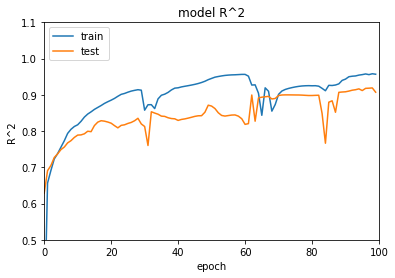

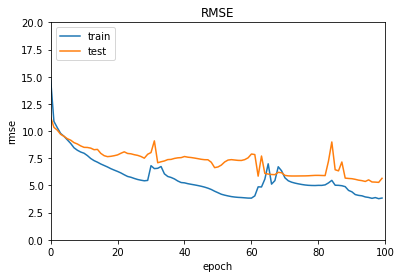

Validation RMSE: 5.65560494627908
Performance increase relative to baseline: -0.0%


In [57]:
model_evaluation(history, history)

In [53]:
# Sam's CNN model
# print(X.shape)
# Feed in shape = (2140, 96, 96, 1)
start_time=time.time()

model2 = Sequential()

model2.add(Conv2D(32, kernel_size = (3,3), strides=(1,1),
                  input_shape=(96,96,1), activation = 'relu'))
model2.add(MaxPool2D(pool_size=(2, 2)))

model2.add(Conv2D(64, kernel_size = (3,3), activation = 'relu'))
model2.add(MaxPool2D(pool_size=(2, 2)))

model2.add(Conv2D(128, kernel_size = (3,3), activation = 'relu'))
model2.add(MaxPool2D(pool_size=(2, 2)))

model2.add(Flatten())
model2.add(Dense(100))
model2.add(Activation('relu'))
model2.add(Dense(100))
model2.add(Activation('softmax'))
model2.add(Dense(30))

#sgd = optimizers.SGD(lr=0.01, momentum=0.9, nesterov=True)
adam = optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model2.compile(loss='mse', optimizer=adam,  metrics=[r_square, rmse])
ext_model = model2.fit(train_data, train_labels, validation_data=[val_data, val_labels], shuffle=False, epochs=epochs, batch_size=20)

total_time=time.time()-start_time
print("The model took {} seconds to run".format(round(total_time,3)))

Train on 1712 samples, validate on 428 samples
Epoch 1/100
1712/1712 [==============================] - 18s 11ms/step - loss: 2535.4480 - r_square: -6.1517 - rmse: 50.3501 - val_loss: 2450.9150 - val_r_square: -5.9495 - val_rmse: 49.5060
Epoch 2/100
1712/1712 [==============================] - 18s 10ms/step - loss: 2378.9138 - r_square: -5.7101 - rmse: 48.7710 - val_loss: 2299.2374 - val_r_square: -5.5194 - val_rmse: 47.9496
Epoch 3/100
1712/1712 [==============================] - 18s 10ms/step - loss: 2231.3801 - r_square: -5.2939 - rmse: 47.2344 - val_loss: 2155.9715 - val_r_square: -5.1131 - val_rmse: 46.4317
Epoch 4/100
1712/1712 [==============================] - 18s 10ms/step - loss: 2091.9747 - r_square: -4.9006 - rmse: 45.7350 - val_loss: 2020.6007 - val_r_square: -4.7293 - val_rmse: 44.9503
Epoch 5/100
1712/1712 [==============================] - 18s 11ms/step - loss: 1960.2806 - r_square: -4.5291 - rmse: 44.2720 - val_loss: 1892.7490 - val_r_square: -4.3667 - val_rmse: 43.504

Epoch 44/100
1712/1712 [==============================] - 18s 10ms/step - loss: 86.3218 - r_square: 0.7569 - rmse: 9.2849 - val_loss: 81.1657 - val_r_square: 0.7701 - val_rmse: 9.0064
Epoch 45/100
1712/1712 [==============================] - 18s 10ms/step - loss: 77.9411 - r_square: 0.7805 - rmse: 8.8221 - val_loss: 73.2250 - val_r_square: 0.7926 - val_rmse: 8.5542
Epoch 46/100
1712/1712 [==============================] - 17s 10ms/step - loss: 70.2981 - r_square: 0.8020 - rmse: 8.3779 - val_loss: 65.9971 - val_r_square: 0.8131 - val_rmse: 8.1207
Epoch 47/100
1712/1712 [==============================] - 18s 10ms/step - loss: 63.3457 - r_square: 0.8216 - rmse: 7.9522 - val_loss: 59.4356 - val_r_square: 0.8317 - val_rmse: 7.7061
Epoch 48/100
1712/1712 [==============================] - 18s 10ms/step - loss: 57.0382 - r_square: 0.8394 - rmse: 7.5453 - val_loss: 53.4960 - val_r_square: 0.8485 - val_rmse: 7.3105
Epoch 49/100
1712/1712 [==============================] - 18s 10ms/step - loss: 

1712/1712 [==============================] - 19s 11ms/step - loss: 10.0586 - r_square: 0.9716 - rmse: 3.1579 - val_loss: 10.4987 - val_r_square: 0.9703 - val_rmse: 3.2197
Epoch 89/100
1712/1712 [==============================] - 19s 11ms/step - loss: 10.0584 - r_square: 0.9716 - rmse: 3.1579 - val_loss: 10.4994 - val_r_square: 0.9703 - val_rmse: 3.2198
Epoch 90/100
1712/1712 [==============================] - 19s 11ms/step - loss: 10.0584 - r_square: 0.9716 - rmse: 3.1579 - val_loss: 10.5000 - val_r_square: 0.9703 - val_rmse: 3.2198
Epoch 91/100
1712/1712 [==============================] - 19s 11ms/step - loss: 10.0584 - r_square: 0.9716 - rmse: 3.1579 - val_loss: 10.5005 - val_r_square: 0.9703 - val_rmse: 3.2199
Epoch 92/100
1712/1712 [==============================] - 19s 11ms/step - loss: 10.0585 - r_square: 0.9716 - rmse: 3.1579 - val_loss: 10.5009 - val_r_square: 0.9703 - val_rmse: 3.2200
Epoch 93/100
1712/1712 [==============================] - 19s 11ms/step - loss: 10.0586 - r_s

Below are the model performance plots after 100 epoches:


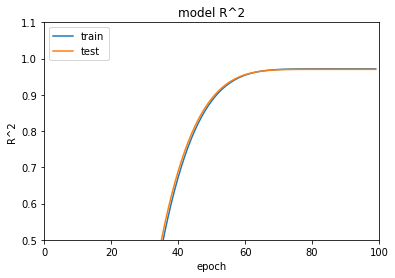

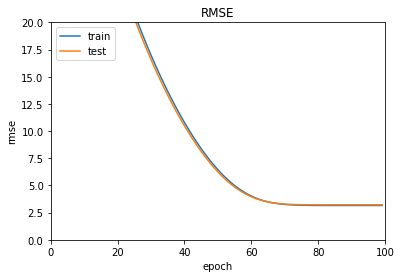

Validation RMSE: 3.220166950582344
Performance increase relative to baseline: 43.06%


In [58]:
model_evaluation(ext_model, history)

In [65]:
# Possible extensions
start_time=time.time()

model3 = Sequential()

model3.add(Conv2D(128, kernel_size = (3,3), input_shape=(96,96,1), activation = 'relu'))
model3.add(AvgPool2D(pool_size=(2, 2)))

model3.add(Conv2D(64, kernel_size = (3,3), padding = 'same', activation = 'relu'))
model3.add(MaxPool2D(pool_size=(2, 2)))

model3.add(Conv2D(32, kernel_size = (3,3), padding = 'same', activation = 'relu'))
model3.add(MaxPool2D(pool_size=(2, 2)))

model3.add(Flatten())
model3.add(Dropout(0.5))
model3.add(Dense(600, activation = 'relu'))
model3.add(Dense(120, activation = 'relu'))
model3.add(Dense(60, activation = 'relu'))
model3.add(Dense(60, activation = 'softmax'))
model3.add(Dense(30))

#sgd = optimizers.SGD(lr=0.01, momentum=0.9, nesterov=True)
adam = optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model3.compile(loss='mse', optimizer=adam,  metrics=[r_square, rmse])
ext_model2 = model3.fit(train_data, train_labels, validation_data=[val_data, val_labels], shuffle=False, epochs=epochs, batch_size=20)

total_time=time.time()-start_time
print("The model took {} seconds to run".format(round(total_time,3)))


Train on 1712 samples, validate on 428 samples
Epoch 1/100
1712/1712 [==============================] - 48s 28ms/step - loss: 2535.4882 - r_square: -6.1518 - rmse: 50.3505 - val_loss: 2450.6770 - val_r_square: -5.9488 - val_rmse: 49.5036
Epoch 2/100
1712/1712 [==============================] - 49s 28ms/step - loss: 2378.5178 - r_square: -5.7090 - rmse: 48.7670 - val_loss: 2298.6737 - val_r_square: -5.5178 - val_rmse: 47.9438
Epoch 3/100
1712/1712 [==============================] - 48s 28ms/step - loss: 2230.7716 - r_square: -5.2921 - rmse: 47.2280 - val_loss: 2155.2890 - val_r_square: -5.1112 - val_rmse: 46.4243
Epoch 4/100
1712/1712 [==============================] - 49s 29ms/step - loss: 2091.3122 - r_square: -4.8987 - rmse: 45.7278 - val_loss: 2019.9124 - val_r_square: -4.7273 - val_rmse: 44.9427
Epoch 5/100
1712/1712 [==============================] - 50s 29ms/step - loss: 1959.5932 - r_square: -4.5271 - rmse: 44.2642 - val_loss: 1892.0316 - val_r_square: -4.3647 - val_rmse: 43.496

Epoch 44/100
1712/1712 [==============================] - 44s 26ms/step - loss: 86.5082 - r_square: 0.7564 - rmse: 9.2949 - val_loss: 81.3408 - val_r_square: 0.7696 - val_rmse: 9.0161
Epoch 45/100
1712/1712 [==============================] - 45s 26ms/step - loss: 78.1204 - r_square: 0.7800 - rmse: 8.8323 - val_loss: 73.3929 - val_r_square: 0.7921 - val_rmse: 8.5640
Epoch 46/100
1712/1712 [==============================] - 45s 26ms/step - loss: 70.4698 - r_square: 0.8016 - rmse: 8.3881 - val_loss: 66.1573 - val_r_square: 0.8126 - val_rmse: 8.1305
Epoch 47/100
1712/1712 [==============================] - 45s 26ms/step - loss: 63.5092 - r_square: 0.8212 - rmse: 7.9625 - val_loss: 59.5878 - val_r_square: 0.8312 - val_rmse: 7.7159
Epoch 48/100
1712/1712 [==============================] - 44s 26ms/step - loss: 57.1932 - r_square: 0.8390 - rmse: 7.5556 - val_loss: 53.6397 - val_r_square: 0.8481 - val_rmse: 7.3203
Epoch 49/100
1712/1712 [==============================] - 44s 26ms/step - loss: 

1712/1712 [==============================] - 48s 28ms/step - loss: 10.0586 - r_square: 0.9716 - rmse: 3.1579 - val_loss: 10.4986 - val_r_square: 0.9703 - val_rmse: 3.2196
Epoch 89/100
1712/1712 [==============================] - 49s 29ms/step - loss: 10.0584 - r_square: 0.9716 - rmse: 3.1579 - val_loss: 10.4993 - val_r_square: 0.9703 - val_rmse: 3.2197
Epoch 90/100
1712/1712 [==============================] - 48s 28ms/step - loss: 10.0584 - r_square: 0.9716 - rmse: 3.1579 - val_loss: 10.4999 - val_r_square: 0.9703 - val_rmse: 3.2198
Epoch 91/100
1712/1712 [==============================] - 45s 27ms/step - loss: 10.0584 - r_square: 0.9716 - rmse: 3.1579 - val_loss: 10.5004 - val_r_square: 0.9703 - val_rmse: 3.2199
Epoch 92/100
1712/1712 [==============================] - 48s 28ms/step - loss: 10.0585 - r_square: 0.9716 - rmse: 3.1579 - val_loss: 10.5009 - val_r_square: 0.9703 - val_rmse: 3.2200
Epoch 93/100
1712/1712 [==============================] - 48s 28ms/step - loss: 10.0586 - r_s

Below are the model performance plots after 100 epoches:


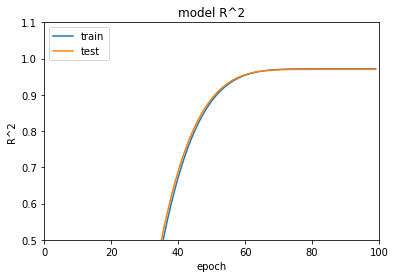

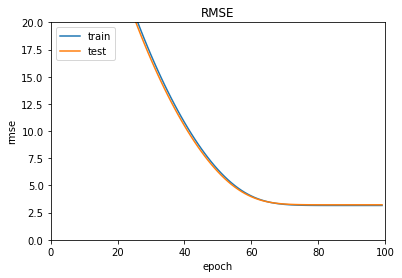

Validation RMSE: 3.2201685036454246
Performance increase relative to baseline: 43.06%


In [66]:
model_evaluation(ext_model2, history)

Below are the model performance plots after 100 epoches:


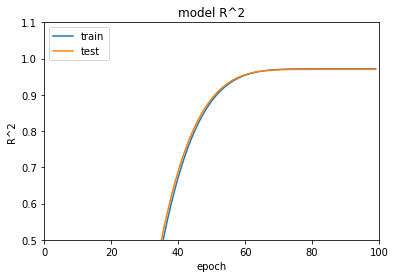

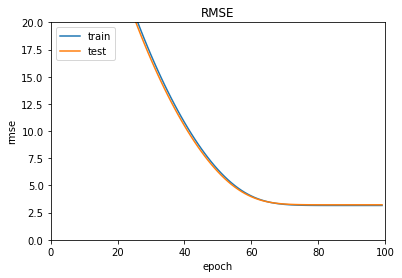

Validation RMSE: 3.2201685036454246
Performance increase relative to baseline: -0.0%


In [67]:
model_evaluation(ext_model2, ext_model)